In [35]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [34]:
#prepare input pipeline

dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [39]:
#build shuffled train / test sets

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [40]:
#create the text encoder

VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize='lower_and_strip_punctuation', split='whitespace', pad_to_max_tokens=True)

#If desired, the user can call this layer's adapt() method on a dataset. When this layer is adapted, it will analyze the dataset, determine the frequency of individual string values, and create a 'vocabulary' from them.
encoder.adapt(train_dataset.map(lambda text, label: text))




In [19]:
#create the model
#The embedding layer uses masking to handle the varying sequence-lengths.
#so I need to pad to remove the varying sequence lengths and then adjust this layer accordingly
#get voab bit may be wrong

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [ ]:
#Train the model

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


In [31]:
sample_text = 'The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.', 'I hated this movie. It was terrible and the acting sucked', 'Dustin hoffman was good, but the rest of the film was pretty average'
#predictions = model.predict(np.array([sample_text]))

In [19]:
path = '/workspace/TensorflowModels/ModelFiles/padded_model/content/padded_model'
new_model = tf.keras.models.load_model(path, compile=True)


In [36]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [45]:
test_loss, test_acc = new_model.evaluate(test_dataset)


391/391 [==============================] - 141s 361ms/step - loss: 0.3548 - accuracy: 0.8642


(0.0, 1.0)

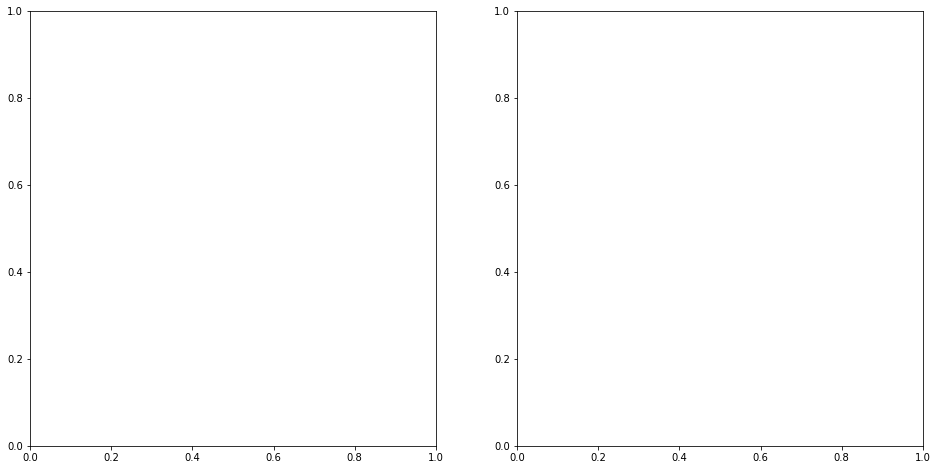

In [50]:
#Evaluate the model

history = new_model.history

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [32]:
new_model.predict(sample_text)

array([[ 0.6486978],
       [-1.9042257],
       [ 0.6161046]], dtype=float32)